# Assignment 2

## Lecture 3 & 4 - Classification & Feature learning, visualization

### Learning Goals
After successfully completing this assignment, you should be able to:
- differentiate between classification and regression tasks
- learn a hypothesis for binary classification by using logistic regression and evaluate it
- evaluate a hypothesis for classification problems by using different metrics
- learn a hypothesis for multi-class classification problems (more than two different label values) and evaluate it
- understand why one might want to use a lower number of features
- understand PCA on an intuitive level

# Table of Contents
1. [Classification](#Classification)
2. [Visualization](#Visualization)

## General Instructions
- Jupyter notebook is supposed to be run cell by cell in order, please do not skip any code cell, this will cause some errors. Also running cells back and forth sometimes might also incur errors. If you feel you lost your track, you can click "Kernel->Restart" from the menu to restart the process.
- Before submitting your assignment, ensure that it does not contain trivial errors by pressing the "validate" button at the top.
- Your implementations are supposed to be added to the places where it reads "YOUR CODE HERE". Please also remove the "raise NotImplementedError()" line before submitting.
- Please DO NOT change the metadata of any cell, cells for demo and instructions are not editable.
- Please DO NOT change the order of solution cell and test cell, you will lose points if the order is changed.
- You can copy lines of code from cells that are not editable, but please DO NOT copy and paste them as cells, this may incur validation error. 
- You can add extra cells or code to help double-check your solution, but please make sure that variables required by tasks are not overwritten, or just delete those extra cells before submitting.
- Please DO NOT change file names in you submission, renamed files can not be recognized by the grading system.
- Reading the documentation of Python libraries is always a good practice, all the Python libraries (Numpy, Pandas, Sklearn,etc.) we utilized in this course provide very well organized documentation for each method/class/function.

In [2]:
%config Completer.use_jedi = False  # enable code auto-completion
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  #data visualization library
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix  # evaluation metrics

from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Classification

## Dataset 
We are going to use weather recordings from the [Finnish Meteorological Institute](https://en.ilmatieteenlaitos.fi/). For your convenience we have already downloaded and stored these recordings in the csv file `FMIData.csv`.  The code snippet below reads in the weather recordings from this file and store them in a Pandas `DataFrame` with the name `df`. 

In [3]:
# Read in the data stored in the file 'FMIData_Assignment.csv'
# Clean the dataframe

df = pd.read_csv('FMIData.csv')
df.drop(columns=['Time zone','Precipitation amount (mm)','Snow depth (cm)','Air temperature (degC)',\
                 'Ground minimum temperature (degC)'],inplace=True)  # drop unrelevant columns

df.columns =['year','m','d','time','max temperature','min temperature'] # rename columns 

# Print the first 5 rows of the DataFrame 'df'
df.head(5)

,year,m,d,time,max temperature,min temperature
0,2020,1,1,00:00,3.4,-2.6
1,2020,1,1,06:00,NaN,NaN
2,2020,1,2,00:00,5.1,1.8
3,2020,1,2,06:00,NaN,NaN
4,2020,1,3,00:00,5.7,4.3


Each row of dataframe `df` contains a weather recording along with a time-stamp. We will use only weather recording with time-stamp `00:00`. For the $i$-th day, we use the value in the column "min temperature" as the feature $x^{(i)}$. The label $y^{(i)}$ of the $i$-th day (datapoint) is determined by the value $\text{maxtmp}^{(i)}$ in the column "max temperature". In particular, we define the label $y^{(i)}$ of the $i$-th day to be equal to 1 if the corresponding weather recording has a positive entry in  the column "max temperature", otherwise we define the label to be $y^{(i)}=0$. More formally, $y^{(i)}=1$ if $\text{maxtmp}^{(i)} > 0$ and $y^{(i)}=0$ if $\text{maxtmp}^{(i)} \leq{0}$. This can be easily realized by using the Pandas method [pd.cut()](https://pandas.pydata.org/docs/reference/api/pandas.cut.html).

In [4]:
# Select only weather recordings whose property 'time' is equal to `00:00`
FMIRawData = df[df['time'] == '00:00']

minvalue = FMIRawData['max temperature'].min() # minimum value of the column 'max temperature'
maxvalue = FMIRawData['max temperature'].max() # maximum value of the column 'max temperature'

if 'binarized max temperature' in FMIRawData.columns:  # delete existing 'binarized max temperature' if there is
    FMIRawData = FMIRawData.drop(['binarized max temperature'],axis=1)
    
bi_labels = [0,1] # new labels to be assigned
bi_cut_bins = [minvalue,0,maxvalue] #cutting intervals/criteria [minvalue,0],(0,maxvalue]

# Encode max temperatures to binary labels

binarized_maxtmp = pd.cut(FMIRawData['max temperature'],\
                                                 bins=bi_cut_bins,labels=bi_labels,include_lowest=True)

# Insert a new column "binarized max temperature" to the datafame
# Int 6 is the position where the new column will be inserted to

FMIRawData.insert(6,'binarized max temperature',binarized_maxtmp) 

# Print the first 5 rows of the DataFrame 'FMIRawData',you will see the new column "binarized max temperature"
FMIRawData.head()

,year,m,d,time,max temperature,min temperature,binarized max temperature
0,2020,1,1,00:00,3.4,-2.6,1
2,2020,1,2,00:00,5.1,1.8,1
4,2020,1,3,00:00,5.7,4.3,1
6,2020,1,4,00:00,4.7,0.7,1
8,2020,1,5,00:00,1.9,-4.9,1


The code snippet below generates two scatter plots and a histogram to visualise the data points in our dataset. The first scatter plot depicts data points (day) using their corresponding min. and max temperature as coordinates. The second scatter plot depicts data points (days) using their min temperature and label $y$ as coordinates. Finally, a histogram is generated to depict the number of data points for each label value.  We can see that the max temperatures of more than 600 days are above zero, only less than 100 days have max temperature below zero.

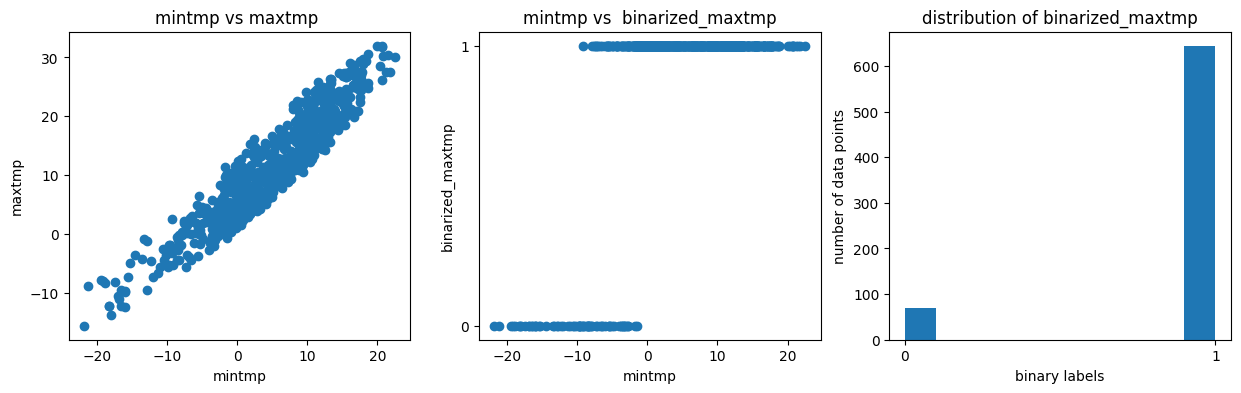

In [5]:
# Visualize data
fig, axes = plt.subplots(1, 3, figsize=(15,4))
axes[0].scatter(FMIRawData['min temperature'],FMIRawData['max temperature']);
axes[0].set_xlabel("mintmp")
axes[0].set_ylabel("maxtmp")
axes[0].set_title("mintmp vs maxtmp ")

axes[1].scatter(FMIRawData['min temperature'],FMIRawData['binarized max temperature']);
axes[1].set_xlabel("mintmp")
axes[1].set_ylabel("binarized_maxtmp")
axes[1].set_yticks([0,1])
axes[1].set_title("mintmp vs  binarized_maxtmp")

axes[2].hist(FMIRawData['binarized max temperature'])
axes[2].set_title('distribution of binarized_maxtmp')
axes[2].set_xlabel("binary labels")
axes[2].set_ylabel('number of data points')
axes[2].set_xticks([0,1])
plt.show()

In the following blocks, we will explore the first classification method we have learnt: **Logistic regression**.

Logistic regression is a ML method that learns the parameters of a linear map $h(x) = w^{T}x$ that is used to classify data points into a finite number of categories or classes. Each class or category is represented by some label value $y$. For the weather data above, the label value $y=0$ means a cold day ($maxtmp \leq{0}$) while the label value $y=1$ means a warm day ($maxtmp >0$). 

There are two basic variants of logistic regression:
 

- Binary logistic regression for data points having binary labels (they belong to one out of two possible classes). Example: Spam or Not

- Multinomial Logistic Regression for data points belonging to one out of three or more categories without ordering. Example: Predicting which color is preferred more (Green, Yellow, Pink)


<div class=" alert alert-warning">

## Student Task A2.1

1. Fit logistic regression model
    - scikit-learn's [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class
    - Just like linear regression you will
        1. Create a classifier object that represents a combination of hypothesis space (linear maps) and loss function (logistic loss)
        2. Call the fit method
        3. Call the predict method
    
    
2. Calculate Accuracy
   
    Use the `accuracy` metric to evaluate the model, the function [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) has been imported for you in the beginning of this notebook.
    
NOTE: the .fit() function uses the (average) logistic loss to measure the quality of a specific linear map $h(x) = w^{T}x$. The accuracy metric instead is based on the average $0/1$ loss which is easier to interpret but results in a more difficult optimization problem (to be solved by .fit()). 
    
</div> 

In [7]:
# Create the feature matrix X, make sure X.shape==(m,1)
# and create label vector y from 'binarized max temperature', y.shape=(m,)
X = FMIRawData['min temperature'].to_numpy().reshape(-1, 1)
y = FMIRawData['binarized max temperature'].to_numpy()

In [8]:
## create a LogisticRegressor clf_1 (do not change the variable names!) and fit the model to the data as:

# clf_1 = ...    # initialise a LogisticRegression classifier, use default value for all arguments
# clf_1...       # fit cfl_1 to data 
# y_pred = ...   # compute predicted labels for training data
# accuracy = ... # compute accuracy on the training set

clf_1 = LogisticRegression()
clf_1.fit(X,y)
y_pred = clf_1.predict(X)
accuracy = accuracy_score(y,y_pred)
print("accuracy of LogReg : ", accuracy)

accuracy of LogReg :  0.9621318373071529


In [9]:
# this cell is for tests, please leave it as it is

## sanity check
assert isinstance(clf_1, LogisticRegression), "please initialise a LogisticRegression classifier"
assert np.isclose(clf_1.coef_,0.65461766), " learnt parameters are incorrect, please check the feature and label"
assert len(y_pred) == len(y), "the lengthe of y_pred is incorrect"

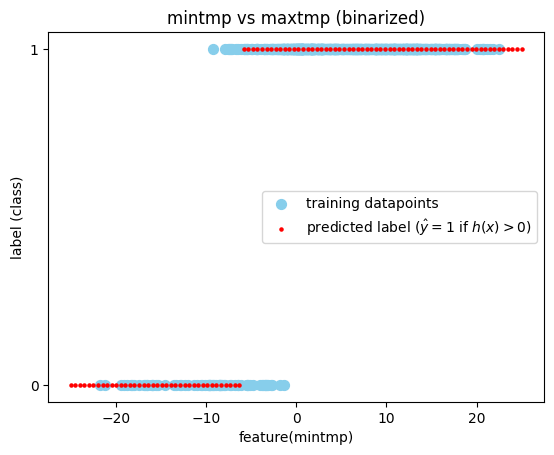

In [10]:
# plot results
fig, ax = plt.subplots()
ax.set_xlabel("feature(mintmp)")
ax.set_yticks([0,1])
ax.set_ylabel('label (class)')
ax.set_title("mintmp vs maxtmp (binarized)")
ax.scatter(X[:,0],y,s=50,c="skyblue",label="training datapoints")
X_fit = np.linspace(-25, 25, 100) 
ax.scatter(X_fit, clf_1.predict(X_fit.reshape(-1, 1)),color='r',s=5,label='predicted label ($\hat{y}=1$ if $h(x) > 0$)') 
ax.legend()
plt.show()

In [11]:
# this cell is for tests, please leave it as it is


## Evaluation Metrics for Classification Models
Now, you have successfully built your classification model and evaluated your model with the most commonly used  metric `accuracy`. Accuracy is defined as the ratio of the number of correct predictions made by the model over all kinds of predictions made. Note that the accuracy is given by $1 - (1/m) \sum_{i=1}^{m} L(.)$ with $L$ being the 0/1 loss (see Sec. 2.3 of [course book](https://github.com/alexjungaalto/MachineLearningTheBasics/blob/master/MLBasicsBook.pdf)).


You may have noticed that the dataset used in task A3.1 is imbalanced in the sense of a significantly varying frequency of different categories. In particular, there have been much more data points with $y^{(i)} =1$ compared to data points with $y^{(i)} = 0$. If you created the logistic model correctly, you have reached a decent accuracy of around 96%, however, note that you can easily get training accuracy around 90% by always predicting max temperature being above zero. In practice, the situation could be even more extreme. For example, when you want to build a classifier for a medical diagnoses of a rare but fatal disease with a very low incidence 0.1%, you can get an accuracy 99.9% without any effort (just by always predicting "no disease"), but the cost of failing to diagnose the disease of a sick person is dire. This is why we will use different types of evaluation metrics to measure the performance of a hypothesis in classification problems. 

Scikit-learn provides multiple metrics, such as [precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score), [recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score), [accurcy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) and [f1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score). These more fine-grained performance measures can be obtained from the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). Confusion matrix, also known as an error matrix, is a K x K matrix used for evaluating the performance of a classification model, where K is the number of label classes. The matrix compares the true label values with those predicted by the model. The $k$-th row and $l$-th column entry of confusion matrix indicates the number of samples with true label being $k$-th class and predicted label being $l$-th class. It gives a overall view of how well the model is performing and what kinds of errors it is making.

This is the confusion matrix for a binary classification model:
TN: true negative, FN: false negative, TP: true positive, FP: false positive


<p> 
<img src="con_mat.png" width="500" height="350">

</p>

<div class=" alert alert-warning">

## Student Task A2.2

Compute confusion matrix to evaluate the performance of the classification model you've just learnt.
The function [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to create confusion matrix is already imported for you.The input for confusion_matrix() should be true labels and predicted labels
    
    
</div> 

In [12]:
## compute confusion matrix as:
# conf_mat = confusion_matrix(..., ...) # NOTE: please pay attention to the order of arguments, the order matters.

conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)

print(conf_mat) #print the confusion matrix

[[ 53  17]
 [ 10 633]]


In [13]:
# this cell is for tests, please leave it as it is

## sanity check
assert conf_mat.shape == (2,2), "Generated confusion matrix has incorrect shape"
assert conf_mat[0, 1] == 17, "Generated confusion matrix is incorrect"


[Text(0, 0.5, 'below zero'), Text(0, 1.5, 'above zero')]

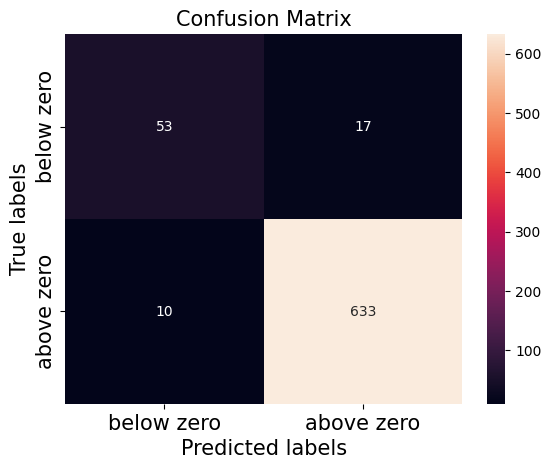

In [14]:
# Visualize the confusion matrix you computed
ax= plt.subplot()

sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
ax.set_title('Confusion Matrix',fontsize=15)
ax.xaxis.set_ticklabels(['below zero', 'above zero'],fontsize=15)
ax.yaxis.set_ticklabels(['below zero', 'above zero'],fontsize=15)

<div class=" alert alert-warning">

## Student Task A2.3

Compute precision from the confusion matrix you have created, consider max temperature above zero as positive.
    
    
</div> 

In [17]:
## compute precision according to the confusion matrix above, and assign it to the variable 'precision':
# precision = ...

tp = conf_mat[1,1]
fp = conf_mat[0,1]
precision = tp / (tp + fp)

print('The precision of the model is: ',precision)
assert isinstance(precision, float)

The precision of the model is:  0.9738461538461538


In [18]:
# this cell is for tests, please leave it as it is

<div class=" alert alert-warning">

## Student Task A2.4
1. Categorize 'max temperature' into 4 categories by using the same [pd.cut()](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) method which is used to binarize 'max temperature' before:
    - 0: $max\_temperature \leq{0}$
    - 1: $0<max\_temperature \leq{5}$
    - 2: $5<max\_temperature \leq{10}$
    - 3: $max\_temperature>10$
2. Fit a multi classification logistic model to predict the label with the same feature `min temperature` as above.
   
    In scikit-learn, binary classification model and multi classification model are combined together, so in fact you will call the same class object [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
    
3. Calculate Accuracy
    
</div> 

In [22]:
# delete existing 'categorized max temperature' if there is
if 'categorized max temperature' in FMIRawData.columns:
    FMIRawData = FMIRawData.drop(['categorized max temperature'], axis=1)

# Categorize 'max temperature' and add a new column "categorized max temperature" to the dataframe:

# multi_labels = [0, ..., ..., ...]
# multi_cut_bins = [minvalue, ..., ..., ..., maxvalue] #cutting intervals/criteria

multi_labels = range(0, 4)
multi_cut_bins = [minvalue, 0, 5, 10, maxvalue]

categorized_maxtmp = pd.cut(FMIRawData['max temperature'],\
                                         bins=multi_cut_bins,labels=multi_labels,include_lowest=True)
FMIRawData.insert(7,'categorized max temperature',categorized_maxtmp)

# print the first 5 rows to see if new column is created correctly
FMIRawData.head()

,year,m,d,time,max temperature,min temperature,binarized max temperature,categorized max temperature
0,2020,1,1,00:00,3.4,-2.6,1,1
2,2020,1,2,00:00,5.1,1.8,1,2
4,2020,1,3,00:00,5.7,4.3,1,2
6,2020,1,4,00:00,4.7,0.7,1,1
8,2020,1,5,00:00,1.9,-4.9,1,1


In [23]:
# this cell is for tests, please leave it as it is

## sanity check
assert multi_cut_bins[2] == 5, "incorrect cut bins"
assert len(FMIRawData['categorized max temperature'].unique()) == 4,  "number of categories is incorrect"
assert FMIRawData.loc[0]['categorized max temperature'] == 1, "label value error"

Text(0.5, 1.0, 'mintmp vs  categorized_maxtmp')

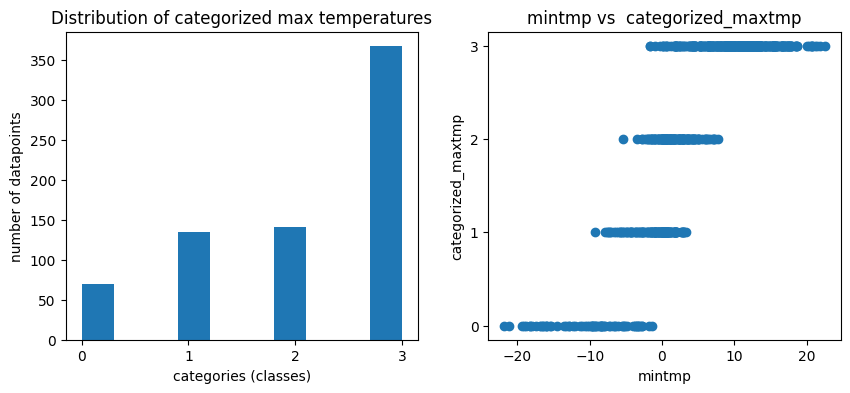

In [24]:
# visualize the distribution of categorized max temperature
# visualize mintmp vs categorized maxtmp
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].hist(FMIRawData['categorized max temperature']) 
axes[0].set_xticks([0,1,2,3])
axes[0].set_xlabel("categories (classes)")
axes[0].set_ylabel("number of datapoints")
axes[0].set_title("Distribution of categorized max temperatures")

axes[1].scatter(FMIRawData['min temperature'],FMIRawData['categorized max temperature']);
axes[1].set_xlabel("mintmp")
axes[1].set_ylabel("categorized_maxtmp")
axes[1].set_yticks([0,1,2,3])
axes[1].set_title("mintmp vs  categorized_maxtmp")

In [25]:
## create the feature matrix X_multi from the column "min temperature", make sure X_multi.shape==(m,1)
## create label vector y_multi from 'categorized max temperature' column, y_multi.shape==(m,)

X_multi = FMIRawData["min temperature"].to_numpy().reshape(-1,1)
y_multi = FMIRawData["categorized max temperature"].to_numpy()


In [26]:
# this cell is for tests, please leave it as it is

#sanity check the shape of the feature matrix and the label vector
assert X_multi.shape == (FMIRawData.shape[0],1), "feature matrix shape error"
assert y_multi.shape == (FMIRawData.shape[0],),"label vector shape error"

In [28]:
## create a LogisticRegressor and train it
## NOTE: please carefully check variable names, DO NOT overwrite variable names used in A3.1

clf_2 = LogisticRegression() # initialise a LogisticRegression classifier, use default value for all arguments
clf_2.fit(X_multi, y_multi) # fit the model to the data  
y_multi_pred = clf_2.predict(X_multi) # compute predicted labels for training datapoints
multi_accuracy = accuracy_score(y_multi, y_multi_pred) #compute accuracy on the training set

print("accuracy of multi classification : ", multi_accuracy)

accuracy of multi classification :  0.7489481065918654


In [29]:
# this cell is for tests, please leave it as it is

# sanity check
assert isinstance(clf_2, LogisticRegression), "please use LogisticRegression model"
assert np.isclose(clf_2.coef_[0],-0.79953543), "learnt parameters are incorrect, please check the feature and label"
assert y_multi_pred[0] == 1, "prediction error, please check the feature"

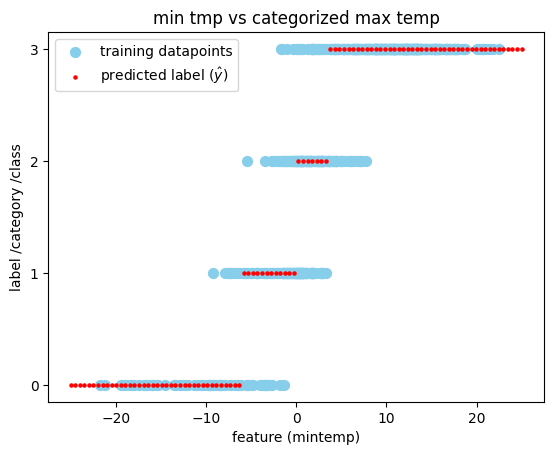

In [30]:
# plot results
# when plotting a single plot, we can omit creating a figure object
plt.scatter(X_multi[:,0],y_multi,s=50,c="skyblue",label="training datapoints")

X_fit = np.linspace(-25, 25, 100) 
plt.scatter(X_fit, clf_2.predict(X_fit.reshape(-1, 1)),color='red',s=5,label="predicted label ($\hat{y}$)") 

plt.xlabel("feature (mintemp)")
plt.ylabel("label /category /class")
plt.yticks([0,1,2,3])
plt.title("min tmp vs categorized max temp")
plt.legend()
plt.show()

In [31]:
# this cell is for tests

# Visualization

We'll go over some ways in which one may lower the amount of features used for training even without domain expertise, i.e., without being able to select them manually based on one's understanding of the relationships between the features and the label. There are multiple reasons one might want to use less features in training: 
* to prevent overfitting (improving the ratio of training samples to features)
* to decrease computational complexity (faster training and prediction)
* visualizing high-dimensional data

## Principal Component Analysis (PCA)
You can think of Principal component analysis as finding a linear subspace of a given dimension (line, plane, hyperplane,...) that is the best fit of high-dimensional vectors. In this case, by best fit we mean that we minimize the squares of the distances of the vectors from the subspace, which corresponds to the information that we'll lose by this method.

If you recall how linear regression works, this may sound familiar. The difference is that linear regression studies functional dependence of the label on the features (how to fit a linear predictor), while PCA does not take the labels into account, it is only concerned about the features. The exact formulations are out of scope of this assignment but for visualizations, see for example [this link](https://www.r-bloggers.com/2010/09/principal-component-analysis-pca-vs-ordinary-least-squares-ols-a-visual-explanation/). 

There are a few pitfalls to PCA that you should be aware of:
* If we set the dimensions of the subspace too low, we may lose too much information to make any reasonable predictions.
* The features generated by PCA are a linear combination of the original features and there's likely no way to interpret them. Imagine a dataset where you try to predict car brand based on engine power and price. Using PCA to reduce the features to 1 might leave us with a feature "0.9\*price-0.1\*power", which doesn't have any real-world meaning. 
* Since PCA doesn't take labels into account, it is entirely possible that the selected features will not be optimal for predicting the labels.
* PCA is very sensitive to statistical properties of the different dimensions (=features).



### MNIST
We begin by fetching the MNIST dataset. This dataset contains 70000 B&W images with resolution 28x28 pixels. Each pixel represents a shade of grey as an 8bit integer (range 0-255) and each image represents a handwritten digit. This leads to a 10-class classification problem, where the goal is to predict the digit based on pixel intensities.

Below we fetch the datset and view one representative of each class to familiarize ourselves with the dataset.

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_MNIST, y_MNIST = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, data_home="/coursedata", cache=True)

OSError: [Errno 30] Read-only file system: '/coursedata'

In [ ]:
# plot the numbers in two rows
def plot_digits(X,y,cols=5,title=None):
    cols = 5
    fig, axs = plt.subplots(2, cols)
    plt.axis('off')
    for digit in range(10):
        # find the first representative of the label
        idx = np.argwhere(y == str(digit))[0]

        # change the vector into a 2D array and plot it
        im = X[idx].reshape(28, 28)
        axs[digit//cols, digit % cols].set_title(f'Class {digit}')
        axs[digit//cols, digit % cols].imshow(im, cmap='gray')
        axs[digit//cols, digit % cols].axis('off')

    # change the spacing between the subplots
    plt.subplots_adjust(wspace=0.1, hspace=-0.3)
    if title is not None:
        fig.suptitle(title,fontsize=14)
        fig.subplots_adjust(top=0.97)
    
plot_digits(X_MNIST,y_MNIST,title="Examples of each class in the MNIST dataset")
plt.show()

In [ ]:

# Split the dataset into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_MNIST, y_MNIST, test_size=0.33, random_state=42)

clf = LogisticRegression(solver='liblinear' )
clf.fit(X_train[:200], y_train[:200])
# can increase training data to reach 91.7 % but it takes 10 minutes on my computer


In [ ]:
def generate_confusion_matrix(y_true, y_pred):
    # visualize the confusion matrix
    ax = plt.subplot()
    c_mat = confusion_matrix(y_true, y_pred)
    sns.heatmap(c_mat, annot=True, fmt='g', ax=ax)

    ax.set_xlabel('Predicted labels', fontsize=15)
    ax.set_ylabel('True labels', fontsize=15)
    ax.set_title('Confusion Matrix', fontsize=15)

y_pred = clf.predict(X_val)
generate_confusion_matrix(y_val, y_pred)
plt.show()

# compute the accuracy
multi_accuracy = accuracy_score(y_val, y_pred)
print(f"Prediction accuracy: {100*multi_accuracy:.2f}%")


####  PCA Features

First, we fit the PCA to the training data. By setting the ``n_components`` parameter, we can choose the dimension of the fitted subspace (=number of output features). A perhaps surprising result is that having computed the PCA, it is very simple to lower the amount of features further: the most important feature (in the PCA sense) is the first one, the most important two are the first two,... 

One way to decide how many components to use is to look at the explained variance ratio of each of the features. These correspond to the "importance" of each feature. Let's plot these:

In [ ]:
# fit the PCA
N = 50
pca = PCA(n_components=N)
X_train_reduced = pca.fit_transform(X_train)

# plot the explained variances
fig, ax1 = plt.subplots(figsize=(12, 5))
color = 'tab:blue'
ax1.bar(1+np.arange(N), pca.explained_variance_ratio_, color=color)
ax1.set_xticks(1+np.arange(N, step=2))
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("Explained variance ratio", color=color)
ax1.set_xlabel("Generated feature")

ax2 = ax1.twinx()
color = 'tab:red'
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(1+np.arange(N), np.cumsum(pca.explained_variance_ratio_), color=color)
ax2.set_ylabel("Cumulative explained variance ratio", color=color)
fig.tight_layout()
plt.show()


If we choose to use 784 components, then the cumulative explained variance ratio will be 1, i.e., no data would be lost. This corresponds to projecting the data to the same space where it originally "lived", i.e. not doing anything. Note, however, that the features will likely still change, even though no data is lost. What happens is essentially a change of basis of the feature space. 

Of course, there's not much use in keeping all the features, so how many features (components) should we keep? There's no clear cut answer to that here and there rarely is. In this case, let's keep 15 components, because the explained variance ratio drops to under 2% per feature around that point. 

In [ ]:
N = 15
pca.set_params(n_components=N)
X_train_reduced = pca.fit_transform(X_train)

Now let's visually confirm that the compression hasn't affected the pictures too much. Based on the representatives chosen, it seems that keeping just 15/784 dimensions still leaves the digits legible, if slightly blurry.

To view the image after dropping the less important features, we need to transform the 15-dimensional vector back into the original 784-dimensional space. For this, we'll use the ``inverse_transform`` method. Mathematically, all of the components form a basis of the original space, so this function creates a linear combination of the first 15 basis vector with coefficients corresponding to the new features.

In [ ]:
# plot the digits with only 15 components
plot_digits(pca.inverse_transform(X_train_reduced), y_train, title="An example of each class with 15 PCA components")
plt.show()

# plot the same picture with different numebrs of features
digit = 4
cols = 8
fig, axs = plt.subplots(2, cols, figsize=(12, 8))
fig.suptitle("An image of a '4' with varying number of PCA components", fontsize=14)
idx = np.argwhere(y_train == str(digit))[0]
for n in 1+np.arange(N):
    X_nfeatures = X_train_reduced[idx]*[1 if i < n else 0 for i in range(N)]
    # transform the data back into the original 784-dimensional space
    im = pca.inverse_transform(X_nfeatures).reshape(28, 28)
    # plot it
    axs[(n-1)//cols, (n-1) % cols].set_title(f"{(n)} feature{'s' if n>1 else ''}")
    axs[(n-1)//cols, (n-1) % cols].imshow(im, cmap='gray')
    axs[(n-1)//cols, (n-1) % cols].axis('off')
# plot the original
axs[-1, -1].set_title(f'original')
axs[-1, -1].imshow(X_train[idx].reshape(28, 28), cmap='gray')
axs[-1, -1].axis('off')
# adjust spacing
fig.subplots_adjust(wspace=0.1, hspace=-0.8, top=1.3)
plt.show()


<div class=" alert alert-warning">

## Student Task A2.5
Use the transformed data ``X_train_reduced`` to train a logistic regressor. Then compute its accuracy on the validation set. Since the logistic regressor will be trained with PCA transformed data, for doing predictions one has to first transform the validation set using the PCA transformation learned on the training set. That can be done using the transform method of the fitted PCA instance (see https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.transform).
<div>

In [ ]:
# clf_2 = # create the object, SET solver='sag'
# clf_2. # fit the data
# y_pred = # compute the prediction on the validating set
# multi_accuracy = # compute the accuracy score

# YOUR CODE HERE
raise NotImplementedError()
print(f"Prediction accuracy: {100*multi_accuracy:.2f}%")
generate_confusion_matrix(y_val, y_pred)
plt.show()


In [ ]:
## test cell for A2.5

# sanity check
assert isinstance(clf_2, LogisticRegression), "You need to use Logistic regression!"


In [ ]:
## test cell for A2.5


## Demo: Data visualization
Another application of PCA is visualization of high-dimensional data. Here, we plot each image as a single point based on its coordinates in the 2D subspace generated by PCA. For example, we can see that 1's seem to be very easy to tell apart and they all look very similar, whereas these two dimensions are certainly not enough to tell apart 4's and 9's in any meaningful way. This confirms what we saw earlier - with only a few components, the 4 looked like a 9!

Note that since the features carry no meaning anymore, we label the axes simply as PCA1 and PCA2.

In [ ]:
plt.figure(figsize=(10, 8))
# convert the labels to numbers, each will be assigned a separate color based on the cmap specified
colors = [int(x) for x in y_train]
sc = plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], s=1, c=colors, cmap='tab10')
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(*sc.legend_elements(), title='digit')
plt.show()
